#**Digit Prediction from Recorded Speech Audio**

We are going to use audio files that record different speakers saying numerical digits. This type of NN could be useful for detecting spoken digits in an audio-based customer service setting with a voice-based chatbot. First, we need to download the data.

In [1]:
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 4234, done.
remote: Counting objects: 100% (562/562), done.
remote: Compressing objects: 100% (550/550), done.
remote: Total 4234 (delta 31), reused 524 (delta 12), pack-reused 3672
Receiving objects: 100% (4234/4234), 30.45 MiB | 20.12 MiB/s, done.
Resolving deltas: 100% (108/108), done.


We can play one of these files to hear what it sounds like... this person is saying the digit 'zero'.

free-spoken-digit-dataset/recordings/4_jackson_35.wav


Total Duration: 0.435 seconds.


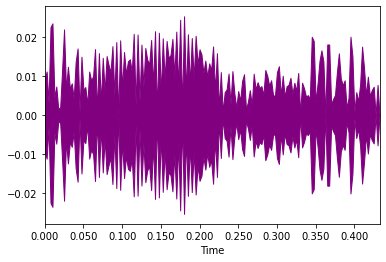

In [2]:
from IPython.display import Audio
from IPython.display import display
import glob
import librosa.display
import librosa
   
basePath = 'free-spoken-digit-dataset/recordings'

for i,file in enumerate(glob.glob(f"{basePath}/*.wav")):
  
  # What's the name of the file? 
  sound_file = f'{file}'
  print(sound_file)

  # Play the audio file.
  wn = Audio(sound_file, autoplay=True) ##
  display(wn)

  # Draw the waveform plot of the audio signal.
  y,sr=librosa.load(sound_file, sr=400) # I am going to be downsampling these files from 8kHz to 400Hz.
  librosa.display.waveplot(y,sr=sr, x_axis='time', color='purple',offset=0.0)

  # Write out how long the file is in seconds.
  print(f'Total Duration: {librosa.get_duration(y=y,sr=sr)} seconds.')

  break

What does .wav data actually look like?

In [3]:
from scipy.io import wavfile

sampling_rate, data = wavfile.read(sound_file) 
print(f'Song is originally sampled at {sampling_rate} times per second.')
print(f'The file contains a total of {len(data)} samples, thus the song length is {len(data)/sampling_rate} seconds.')
print(f'Here are the first 15 samples...{data[:15]}.')

Song is originally sampled at 8000 times per second.
The file contains a total of 3462 samples, thus the song length is 0.43275 seconds.
Here are the first 15 samples...[345 326 323 343 251 237 208 263 340 369 404 524 505 357 323].


#*First Attempt: Basic LSTM*



For each song, let's convert it into numeric sequences, and construct its label from the file name.


In [18]:
from pathlib import Path
from scipy.signal import decimate

def processSong(song):
  
  filename = Path(song).stem
  label = int(filename[0])

  sampling_rate, data = wavfile.read(song)
  return label,sampling_rate,data

labels = []
sample_rates = []
sequences = []

for i,file in enumerate(glob.glob(f"{basePath}/*.wav")):
  label, sample_rate, sequence = processSong(file)
  labels.append(label)
  sample_rates.append(sample_rate/8)

  sequence = decimate(sequence,8) # Downsample with filter by a factor of 4, down to 2000

  sequences.append(sequence)

sequences[0]

array([ 7.59235862e+02, -1.53664018e+02,  6.18547768e+02, -8.56682142e+02,
       -1.92367654e+03,  2.17112376e+03, -4.13021152e+02,  4.33998905e+02,
        3.43343062e+02, -4.39615533e+02,  2.01835995e+03, -3.97657804e+03,
       -3.14491822e+01,  2.12957927e+03, -2.11064432e+02,  1.08010291e+03,
       -1.80987194e+03, -8.18431474e+01,  9.53621083e+02,  1.96022567e+03,
       -2.58722488e+03, -1.67214881e+03,  2.20566576e+03, -4.01079444e+02,
        6.07941940e+02, -9.78014107e+02,  1.80373315e+02,  1.71703965e+03,
        1.30208856e+03, -3.43788510e+03, -1.70415321e+03,  2.66387909e+03,
        4.67770670e+02, -1.72916036e+02, -1.44908963e+03,  3.46794509e+02,
        1.62416851e+03,  1.79906234e+03, -3.22506128e+03, -1.94234493e+03,
        2.44768939e+03,  6.35805129e+02, -5.81987860e+02, -1.12977638e+03,
        7.65440358e+02,  1.61614631e+03,  1.36993508e+03, -3.94560387e+03,
       -1.34906907e+03,  2.64508469e+03,  1.14376787e+03, -7.87544944e+02,
       -1.79306667e+03,  

All songs have been 'downsampled' to 320 samples per second. We have ragged lists of numeric values that we need to pad.

In [19]:
for i in range(3):
  print(f'Recording {i} has a sampling rate of {sample_rates[i]}, and it is {len(sequences[i])} elements long.')

Recording 0 has a sampling rate of 1000.0, and it is 433 elements long.
Recording 1 has a sampling rate of 1000.0, and it is 396 elements long.
Recording 2 has a sampling rate of 1000.0, and it is 390 elements long.


Here we will make an array of 0's and fill in our audio sequences from the left. The longest sequence is an outlier, so we will truncate some recordings.


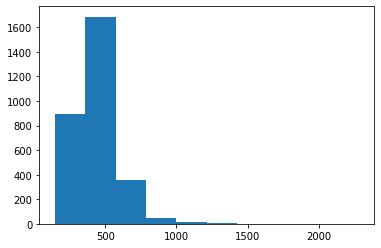

The longest list is 2283 long, but most lists are much shorter.
(3000, 700)


In [20]:
import tensorflow as tf
import numpy as np
import statistics
import matplotlib.pyplot as plt
from keras.preprocessing import sequence

len_lists = [len(x) for x in sequences]
plt.hist(len_lists)
plt.show()
print(f'The longest list is {max(len_lists)} long, but most lists are much shorter.')

labels = np.stack(labels)
padded_sequences = sequence.pad_sequences(sequences, maxlen=700)

# Shuffling observations, because certain voices come earlier, and others later.
shuffled_indices= np.arange(padded_sequences.shape[0])
np.random.shuffle(shuffled_indices)
padded_sequences = padded_sequences[shuffled_indices,:]
labels = labels[shuffled_indices]

print(padded_sequences.shape)

#*Define our LSTM*

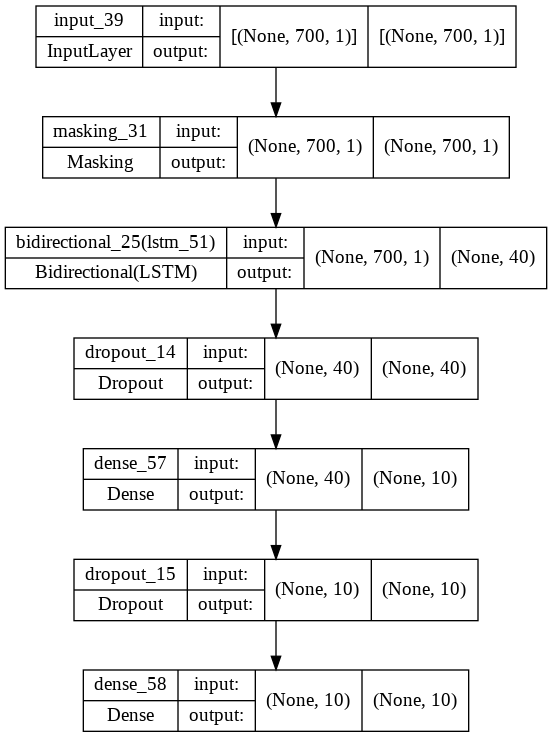

In [72]:
from tensorflow import keras
from keras import layers

input = keras.Input(shape=(700,1)) # We have 700 time steps, with an input of dimension = 1 at each step, i.e., a scalar.
masking_layer = layers.Masking()(input) # Ignore the zero padding.

# Note: We shouldn't use BatchNormalization() with sequence data, because it is not effective / can be harmful. 
# Layer normalization is a better alternative; it normalizes values in a sequence on a per-sequence basis (rather than across sequences in the batch).
# There is a tensorflow add-on (tfa library) layer that provides an LSTM layer that incorporates layer-normalization, if you want to try it out.

# Note: LSTM units > 1 means you have many parallel LSTMs learning to remember something different about the sequences you pass in. 

# If we were to say "return_sequences=True", then this LSTM would return transformations of the sequence (rather than a compressed representation)
# Each LSTM unit will push the sequence of 700 values through a series of recurring LSTM calculations.
# Each LSTM unit will produce a compressed representation of the sequence. If we have 20 LSTM units, we get 20 representations (think of this as a 20-dim embedding of the audio sequence)
# The layer is bi-directional, so we get 2* the number of LSTM outputs, one in each direction, concatenated together, so actually a 40 dim embedding of the audio sequence.
x = layers.Bidirectional(layers.LSTM(units=20))(masking_layer) 

# Then I'm passing that to a couple of Dense layers that can figure out how to mix and match and recombine the embedding.
# Add some dropout so it doesn't start to overfit immediately
x = layers.Dropout(0.3)(x)
x = layers.Dense(10, activation="relu")(x)
x = layers.Dropout(0.3)(x)

# Finally, we pass the result to a 10-digit softmax output.
output = layers.Dense(10,activation="softmax")(x)

model = keras.Model(inputs=input,outputs=output)

model.compile(optimizer="rmsprop",loss="sparse_categorical_crossentropy", metrics=['accuracy'])

keras.utils.plot_model(model,show_shapes=True)

Let's try fitting this model... this approach alone (of learning compressed representations, i.e., embeddings, of the audio sequence) is sufficient to get us to 50% accuracy in our classification task. That's impressive, or it's not, depending on how you think about it. 

In [73]:
# We are making a different callback so we don't overwrite our last model (we might want to compare them)
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="audio_digits.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(padded_sequences,labels,validation_split=0.2,batch_size=100,epochs=100,callbacks=callbacks)

Epoch 1/100
24/24 [==============================] - 28s 921ms/step - loss: 2.4236 - accuracy: 0.0921 - val_loss: 2.3045 - val_accuracy: 0.1000
Epoch 2/100
24/24 [==============================] - 20s 856ms/step - loss: 2.3553 - accuracy: 0.1000 - val_loss: 2.3038 - val_accuracy: 0.0950
Epoch 3/100
24/24 [==============================] - 20s 849ms/step - loss: 2.3259 - accuracy: 0.1142 - val_loss: 2.3048 - val_accuracy: 0.1067
Epoch 4/100
24/24 [==============================] - 20s 851ms/step - loss: 2.3114 - accuracy: 0.1150 - val_loss: 2.3016 - val_accuracy: 0.1067
Epoch 5/100
24/24 [==============================] - 20s 842ms/step - loss: 2.3086 - accuracy: 0.1067 - val_loss: 2.3009 - val_accuracy: 0.1033
Epoch 6/100
24/24 [==============================] - 20s 845ms/step - loss: 2.3035 - accuracy: 0.1200 - val_loss: 2.3006 - val_accuracy: 0.1100
Epoch 7/100
24/24 [==============================] - 20s 841ms/step - loss: 2.3039 - accuracy: 0.1079 - val_loss: 2.2997 - val_accuracy:

Plot loss and accuracy over training... the model peaks at about 55% accuracy.

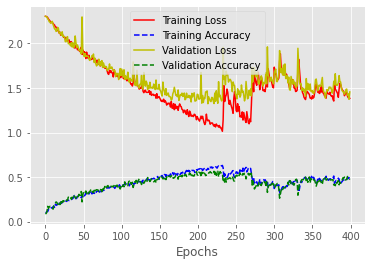

In [ ]:
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

plt.plot(history.history['loss'],c='r')
plt.plot(history.history['accuracy'],c="b",linestyle="dashed")
plt.plot(history.history['val_loss'],c='y')
plt.plot(history.history['val_accuracy'],c='g',linestyle="dashed")
plt.xlabel("Epochs")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()